In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
# sys.path.append( '../src/' ) # local version

from ml.preprocessing import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing

## Reading excel sheets

In [ ]:
%%time
file = './drive/My Drive/thesis-workspace/datasets/dataset-residential.csv' # drive
# file = '../datasets/dataset-residential.csv' # local
df = pd.read_csv( file, index_col = 'date', parse_dates = [ 'date' ] )
df

CPU times: user 40.3 s, sys: 259 ms, total: 40.5 s
Wall time: 40.5 s


## Visualization

In [ ]:
# plot_env_vars( df.index.astype( str ), df[ 'tem' ], df[ 'hum' ], df[ 'occ' ] )
# plot_single( df.index.astype( str ), df[ 'pre' ], 'Pressure' )

# Features Selection

In [ ]:
from ml.feature_selection import *
from ml.generation import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Recursive Feature Elimination 

In [ ]:
x_train, x_test, y_train, y_test = split_data( df, test_size = 0.20 )
x_train, x_test = standardize( x_train, x_test )
selected_rfe = select_k_rfe( x_train, y_train, df.columns[ : -1 ], 1 )
selected_rfe

,rank,selected
hum,1,1
pre,2,0
tem,3,0
ven,4,0
alt,5,0


## 3.2 Selecting K-best

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision = 2)
selected_kbest = select_k_best( x_train, y_train, df.columns[ : -1 ], 3 )
selected_kbest

,score,p-value
tem,"42,166.13",0.00
ven,"41,196.57",0.00
hum,"22,034.33",0.00
alt,"11,741.74",0.00
pre,"11,732.62",0.00


## 3.3 Feature Correlation

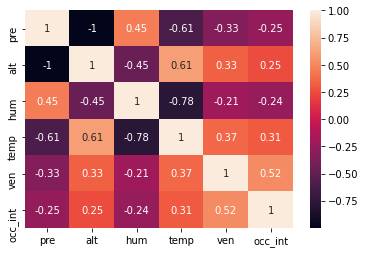

In [ ]:
occ_int = df[ 'occ' ].replace( { 'E': 0, 'L':0, 'M':2, 'H':1 } )
temp = pd.concat( [ df, occ_int ], axis = 1 ).dropna( thresh = 2 )
temp.columns = [ 'pre', 'alt', 'hum', 'temp', 'ven', 'occ', 'occ_int' ]

sns.heatmap( temp.corr(), annot = True )

# Datasets Generation

In [ ]:
from ml.generation import *
import enum

class DF( enum.Enum ):
    _OR = 0
    _10SEC = 1
    _1MIN = 2
    _5MIN = 3

AGG = [ 'mean' ]
dfs = { DF._OR: df, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }
grids = { DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }

## Different resolutions generation

### 10 sec. avg.

In [ ]:
dfs[ DF._10SEC ] = df_10sec_avg( df.reset_index( drop = False ), AGG ).set_index( 'date' )

### 1 minute samples

In [ ]:
dfs[ DF._1MIN ] = df_1min_samples( df )

### 5 minutes samples

In [ ]:
dfs[ DF._5MIN ] = df_5min_samples( df )

## Data splitting, standarization and balancing

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._OR: 1, 
    DF._10SEC: 1, 
    DF._1MIN: 1, 
    DF._5MIN: 1 
}

for k, d in dfs.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    dfs[ k ] = temp

Before balancing: DF._OR Counter({'L': 162180, 'E': 40737, 'M': 28281, 'H': 5460})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After balancing: DF._OR Counter({'H': 162188, 'E': 162187, 'L': 162180, 'M': 161949})

Before balancing: DF._10SEC Counter({'L': 16223, 'E': 4084, 'M': 2826, 'H': 536})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After balancing: DF._10SEC Counter({'M': 16256, 'L': 16223, 'H': 16216, 'E': 16200})

Before balancing: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN Counter({'E': 2737, 'H': 2732, 'L': 2730, 'M': 2724})

Before balancing: DF._5MIN Counter({'L': 553, 'E': 136, 'M': 96, 'H': 19})
After balancing: DF._5MIN Counter({'M': 558, 'E': 556, 'L': 553, 'H': 551})



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

# Classification

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from ml.classification import *

params_knn = [ { 
    'n_neighbors': [ 1, 3, 5 ], 
    'p': [ 2 ], # mikowsky distance = euclidian distance
    'algorithm': [ 'ball_tree', 'kd_tree' ] # removed brute force due to the dataset size
} ]

## Regular

In [ ]:
%%time
for k, df in dfs.items():
    # if( k != DF._10SEC and k != DF._1MIN ):
    print( 'Dataset ', k, len( df ) )
    train_and_test( 
            KNeighborsClassifier(), params_knn, 
            df[ X_TRAIN ], df[ Y_TRAIN ], 
            df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._OR 4
Best params:  {'algorithm': 'kd_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9984479660017049
Test Accuracy:  0.9928505028310657
Dataset  DF._10SEC 4
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.997688567900021
Test Accuracy:  0.9854680635349781
Dataset  DF._1MIN 4
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9951019893494735
Test Accuracy:  0.9688128772635815
Dataset  DF._5MIN 4
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9801689698748524
Test Accuracy:  0.9253731343283582
CPU times: user 3h 8min 38s, sys: 7.22 s, total: 3h 8min 45s
Wall time: 3h 8min 47s


## PCA

In [ ]:
%%time
for k, df in dfs.items():
    # if( k != DF._10SEC and k != DF._1MIN ): 
    print( 'Dataset ', k )
    grids[ k ] = train_and_test( 
            make_pipeline( PCA( .95 ), KNeighborsClassifier() ), 
            prefix_params( params_knn, 'kneighborsclassifier' ), 
            df[ X_TRAIN ], df[ Y_TRAIN ], 
            df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._OR
Best params:  {'kneighborsclassifier__algorithm': 'kd_tree', 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2}
Training Accuracy 0.9928728265862794
Test Accuracy:  0.9907546691456097
Dataset  DF._10SEC
Best params:  {'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2}
Training Accuracy 0.9976500459115238
Test Accuracy:  0.9854680635349781
Dataset  DF._1MIN
Best params:  {'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2}
Training Accuracy 0.9919435284142514
Test Accuracy:  0.9647887323943662
Dataset  DF._5MIN
Best params:  {'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2}
Training Accuracy 0.9758856141209081
Test Accuracy:  0.9104477611940298
CPU times: user 1h 36min 24s, sys: 1min 18s, total: 1h 37min 43s
Wall time: 1h 36min 12s


# Evaluation

In [ ]:
from ml.evaluation import *

## Learning Curves

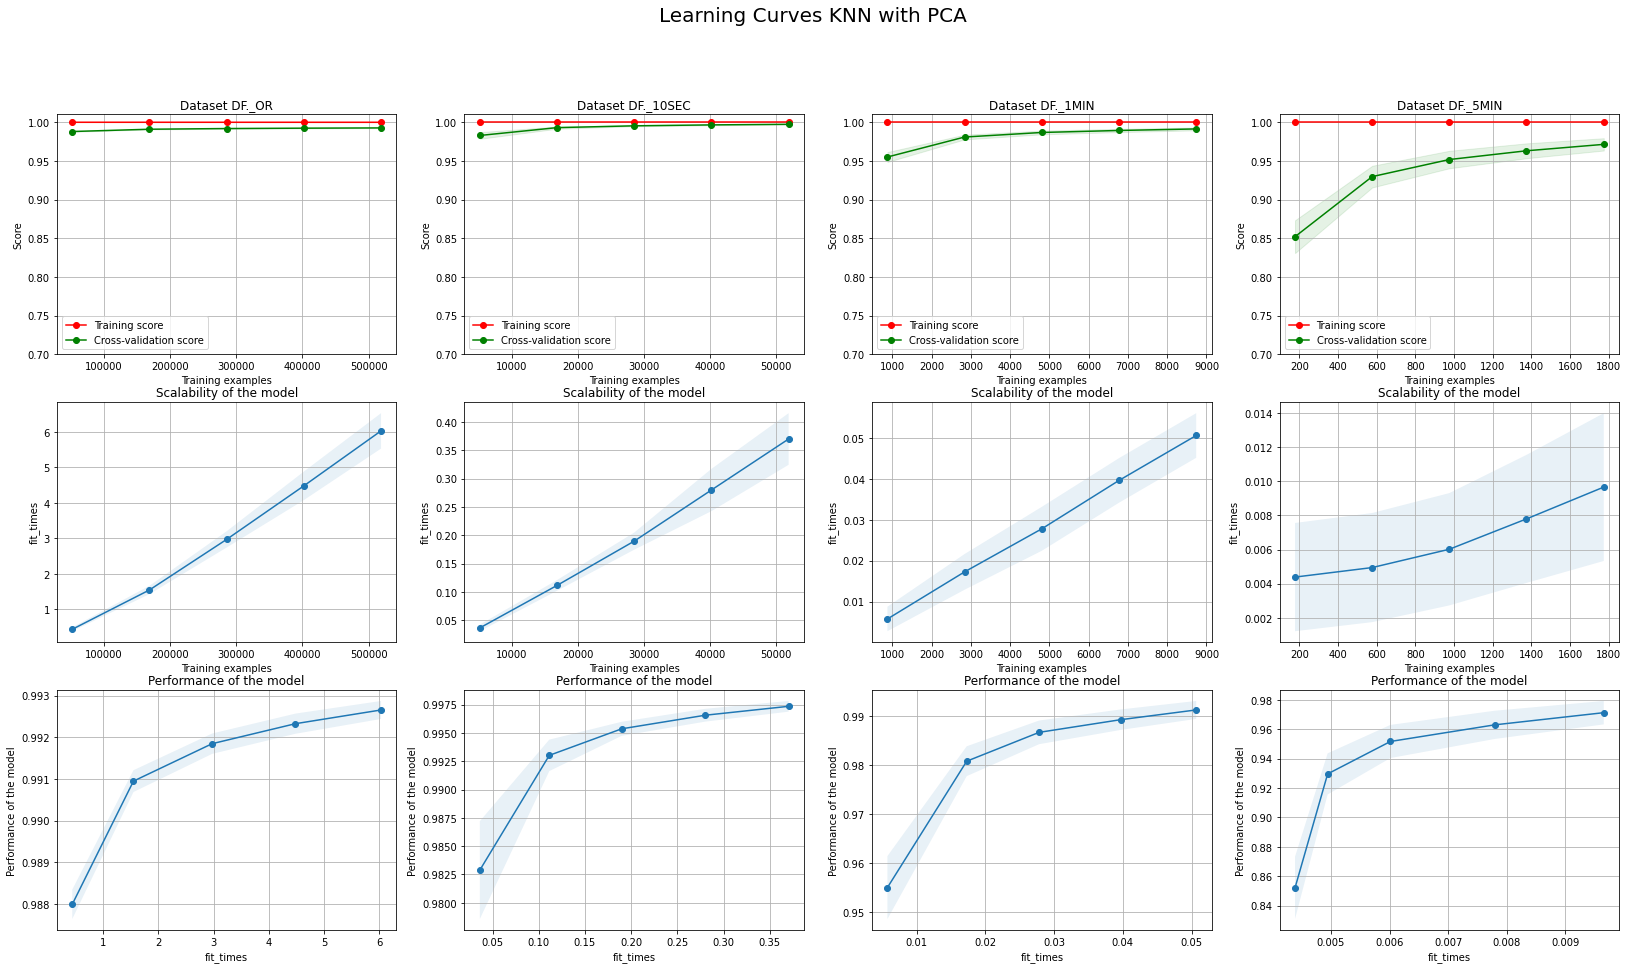

CPU times: user 55.3 s, sys: 2.17 s, total: 57.4 s
Wall time: 1h 55min 38s


In [ ]:
%%time
temp = [ item for item in dfs.items() if item[ 0 ] not in [] ]
plot_learning_curves( temp, grids, 'KNN' )